### Ploting buckets after training

In [1]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
from annoy import AnnoyIndex
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [2]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

Using TensorFlow backend.


In [3]:
MAX_SEQUENCE_LENGTH_T = 20 # 100
MAX_SEQUENCE_LENGTH_D = 20 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [38]:
# Domain to use
DOMAIN = 'openoffice'
METHOD = 'baseline_'
EMBEDDING_METHOD = 'keras'
PREPROCESSING = 'bert'
# Dataset paths
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Save model
SAVE_PATH = '{}@number_of_epochs@_feature@number_of_epochs@epochs_64batch({})'.format(METHOD, DOMAIN)
SAVE_PATH_FEATURE_1_EPOCH = '{}_preprocessing_{}1_feature_1epochs_64batch({})'.format(PREPROCESSING, METHOD,  DOMAIN)
SAVE_PATH_FEATURE = '{}_preprocessing_{}@number_of_epochs@_feature_@number_of_epochs@epochs_64batch({})'.format(PREPROCESSING, METHOD, DOMAIN)

# Extract CORPUs
EXTRACT_CORPUS = False

In [5]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [6]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [7]:
"Total vocabulary: {}".format(len(token_dict))

'Total vocabulary: 30522'

In [8]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [9]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

In [10]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


98070

In [11]:
%%time

experiment.load_bugs()
len(baseline.sentence_dict)


CPU times: user 9.03 s, sys: 850 ms, total: 9.88 s
Wall time: 9.86 s


In [12]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [13]:
%%time

experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')
# Read and create the test queries duplicates
experiment.set_retrieval(retrieval, baseline, DOMAIN)

CPU times: user 2.34 s, sys: 40.4 ms, total: 2.38 s
Wall time: 2.38 s


In [14]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [15]:
from sklearn.manifold import TSNE
import random

def plot_2d(test_labels, tsne_features, categories, colors=None):
    if colors == None:
        colors = [(random.uniform(.25, .75), random.uniform(.5, .75), random.uniform(.5, .75)) for i in enumerate(test_labels)]
    plt.figure(figsize=(10, 10))
    test_labels = np.asarray(test_labels)
    for c_color, c_label in zip(colors, categories):
        plt.scatter(tsne_features[np.where(test_labels == c_label), 0],
                    tsne_features[np.where(test_labels == c_label), 1],
                    marker='o',
                    color=c_color,
                    linewidth='1',
                    alpha=0.9,
                    label=c_label)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE on Buckets')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), prop={'size': 22})
    #plt.savefig('clothes-dist.png')
    plt.show(block=False)
    if colors != None:
        return colors

def create_features(x_test_features):
    tsne_obj = TSNE(n_components=2,
                            init='pca',
                            random_state=101,
                            method='barnes_hut',
                            n_iter=500,
                            verbose=0)
    tsne_features = tsne_obj.fit_transform(x_test_features)
    return tsne_features

### Model 1000

In [32]:
'modelos/model_' + SAVE_PATH_FEATURE.replace('@number_of_epochs@', '1000') + '.h5'

'modelos/model_bert_preprocessing_baseline_1000_feature_1000epochs_64batch(openoffice).h5'

In [33]:
import os
from keras.models import load_model
import keras.backend as K
from keras_bert import get_custom_objects

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = load_model('modelos/model_' + SAVE_PATH_FEATURE.replace('@number_of_epochs@', '1000') + '.h5', custom_objects=get_custom_objects())

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Model 1

In [39]:
'modelos/model_' + SAVE_PATH_FEATURE_1_EPOCH + '.h5'

'modelos/model_bert_preprocessing_baseline_1_feature_1epochs_64batch(openoffice).h5'

In [40]:
model_1_epoch = load_model('modelos/model_' + SAVE_PATH_FEATURE_1_EPOCH + '.h5', custom_objects=get_custom_objects())

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [41]:
buckets_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 2]
buckets_biggest_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 2]
buckets_3_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 3]
buckets_5_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 5]
buckets_between_5_and_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 5 and len(retrieval.buckets[bucket]) <= 10]
buckets_biggest_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 10]

In [42]:
len(buckets_2_dups), len(buckets_3_dups), len(buckets_5_dups), len(buckets_between_5_and_10_dups), len(buckets_biggest_10_dups)

(8824, 3327, 1325, 2868, 3285)

In [50]:
import numpy as np
from keras import layers

def create_tsne_vector(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data = [], [], [], [], []
    categories = []
    bucket_labels = set()
    
    config = model.get_config()
    if method == 'keras':
        max_vocab = config['layers'][4]['config']['layers'][1]['config']['input_dim']
    if method == 'dwen':
        max_vocab = 1

    for row  in bucket_dups_selected:
        bug_id, bucket_id = row
        # bucket and dups
        if bug_id not in baseline.bug_set: continue
        if bug_id in retrieval.buckets:
            label = 'duplicate_of_{}'.format(bucket_id)
            categories.append(label)
            bucket_labels.add(label)
        else:
            dup_label = 'duplicate_of_{}'.format(bucket_id)
            categories.append(dup_label)
            bucket_labels.add(dup_label)
        bug = baseline.bug_set[bug_id]
        
        if method == 'keras' or method == 'dwen':
            title_data.append([ max_vocab - 1 if v > max_vocab else v for v in bug['title_token']])
        else:
            title_data.append(bug['title_word'])
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        
        if method == 'keras' or method == 'dwen':
            desc_data.append([ max_vocab - 1 if v > max_vocab else v for v in bug['description_token']])
        else:
            desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        info_data.append(experiment.retrieval.get_info(bug))

    bucket_labels = list(bucket_labels)
    
    if method == 'keras':
        test_features = model.predict([ np.array(title_data), np.array(desc_data), np.array(info_data) ])
    if method == 'bert':
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data) ])
    elif method == 'dwen':
        test_features = model.predict([ np.array(title_data), np.array(desc_data) ])
    
    return bucket_labels, test_features, categories

### Select random buckets

In [44]:
# selected_buckets = [ 47708, 228156, 132573, 132662, 207563]
# [226761, 211165,  60740, 172436, 160273]
# [146677, 118038, 207060, 236101,  35870] - best
# [ 47708, 228156, 132573, 132662, 207563] - best
# selected_buckets = np.random.choice(buckets_biggest_10_dups, 5)
selected_buckets = [119525, 1601, 37793, 103839, 16268]

In [45]:
selected_buckets

[119525, 1601, 37793, 103839, 16268]

### Eclipse
#### [ 34940,   6749, 264112,  19771,  63692]

### NetBeans
#### [158328,  73960,  14803, 212061, 123467]

### Open Office

##### [119525,   1601,  37793, 103839,  16268]

In [46]:
selected_buckets

[119525, 1601, 37793, 103839, 16268]

In [47]:
bucket_dups_selected = []
for bucket in selected_buckets:
    bucket_dups_selected += [(bug_id, bucket) for bug_id in retrieval.buckets[bucket]]

### Model trained with 1 epoch

In [51]:
bucket_labels_1epoch, test_features_1epoch, categories_1epoch = create_tsne_vector(model_1_epoch, method=EMBEDDING_METHOD)

### Select random buckets

In [53]:
bucket_labels, test_features, categories = create_tsne_vector(model, method=EMBEDDING_METHOD)

### Visualizing bucket space

Plota um conjunto de duplicados pintando o mestre de uma cor e os seus duplicados de outra

In [54]:
colors = [(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.99, 0.9, 0), (0.9, 0.4, 0)]

### 1 epoch

In [55]:
test_features_1epoch.shape, len(categories_1epoch), len(bucket_labels_1epoch)

((85, 900), 85, 5)

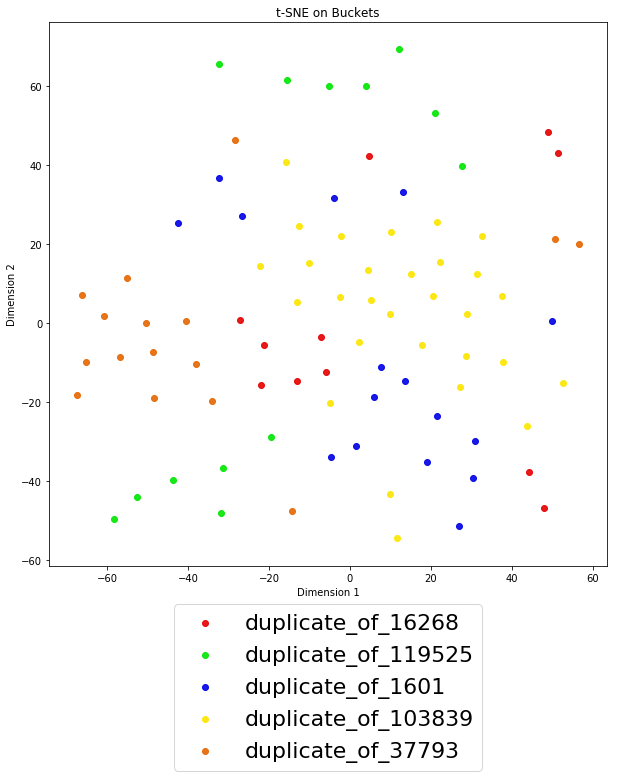

In [56]:
tsne_features_1epoch = create_features(test_features_1epoch)

colors = plot_2d(categories_1epoch, tsne_features_1epoch, bucket_labels_1epoch, colors=colors)

### 1000 epochs

In [57]:
test_features.shape, len(categories), len(bucket_labels)

((85, 900), 85, 5)

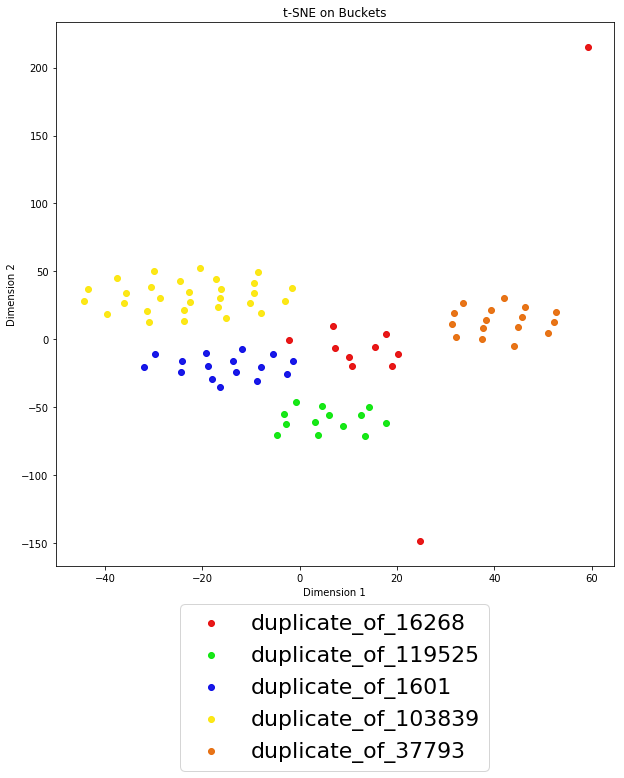

In [58]:
tsne_features = create_features(test_features)

_ = plot_2d(categories, tsne_features, bucket_labels, colors=colors)